In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import time

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

TRAFFIC_DIRECTION = 'sent'

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

traffic_training_complete = pd.read_csv(r'./data/dataset_7day_traffic.csv', index_col=0)
traffic_training_processed_complete = traffic_training_complete[[TRAFFIC_DIRECTION]]
traffic_training_scaled_complete = scaler.fit_transform(traffic_training_processed_complete)


In [4]:
# plt.plot(time, sin, label='sine (with noise)');
# plt.legend();
traffic_training_scaled_complete

array([[0.07321346],
       [0.14797511],
       [0.02808788],
       ...,
       [0.97369893],
       [0.70413978],
       [0.83002709]])

# Data Preprocessing

In [5]:
df = pd.DataFrame(traffic_training_scaled_complete, columns=[TRAFFIC_DIRECTION])
df.head(5)

df_original = pd.DataFrame(traffic_training_processed_complete, columns=[TRAFFIC_DIRECTION])
df_original.head(5)

,sent
1583884800,180.702748
1583884860,262.899616
1583884920,131.089328
1583884980,250.765633
1583885040,218.973629


In [6]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

train_original, test_original = df_original.iloc[0:train_size], df_original.iloc[train_size:len(df_original)]

test.head()

3235 809


,sent
3235,0.065643
3236,0.013720
3237,0.147394
3238,0.059034
3239,0.119908


In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
time_steps = 60

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train[TRAFFIC_DIRECTION], time_steps)
X_test, y_test = create_dataset(test, test[TRAFFIC_DIRECTION], time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3175, 60, 1) (3175,)
(749, 60, 1) (749,)


# Modeling

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

model = keras.Sequential()
# model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(keras.layers.Dense(1))

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

# model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Training

In [10]:
start_time = time.time()
EPOCHS = 5
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.1, 
    verbose=1
)

print("Time taken: ", time.time()-start_time)


Train on 2857 samples, validate on 318 samples
Epoch 1/5
2857/2857 [==============================] - 44s 15ms/sample - loss: 0.0299 - val_loss: 0.0030
Epoch 2/5
2857/2857 [==============================] - 32s 11ms/sample - loss: 0.0217 - val_loss: 0.0031
Epoch 3/5
2857/2857 [==============================] - 31s 11ms/sample - loss: 0.0220 - val_loss: 0.0029
Epoch 4/5
2857/2857 [==============================] - 29s 10ms/sample - loss: 0.0212 - val_loss: 0.0029
Epoch 5/5
2857/2857 [==============================] - 30s 11ms/sample - loss: 0.0208 - val_loss: 0.0032
Time taken:  166.70957255363464


## Evaluation

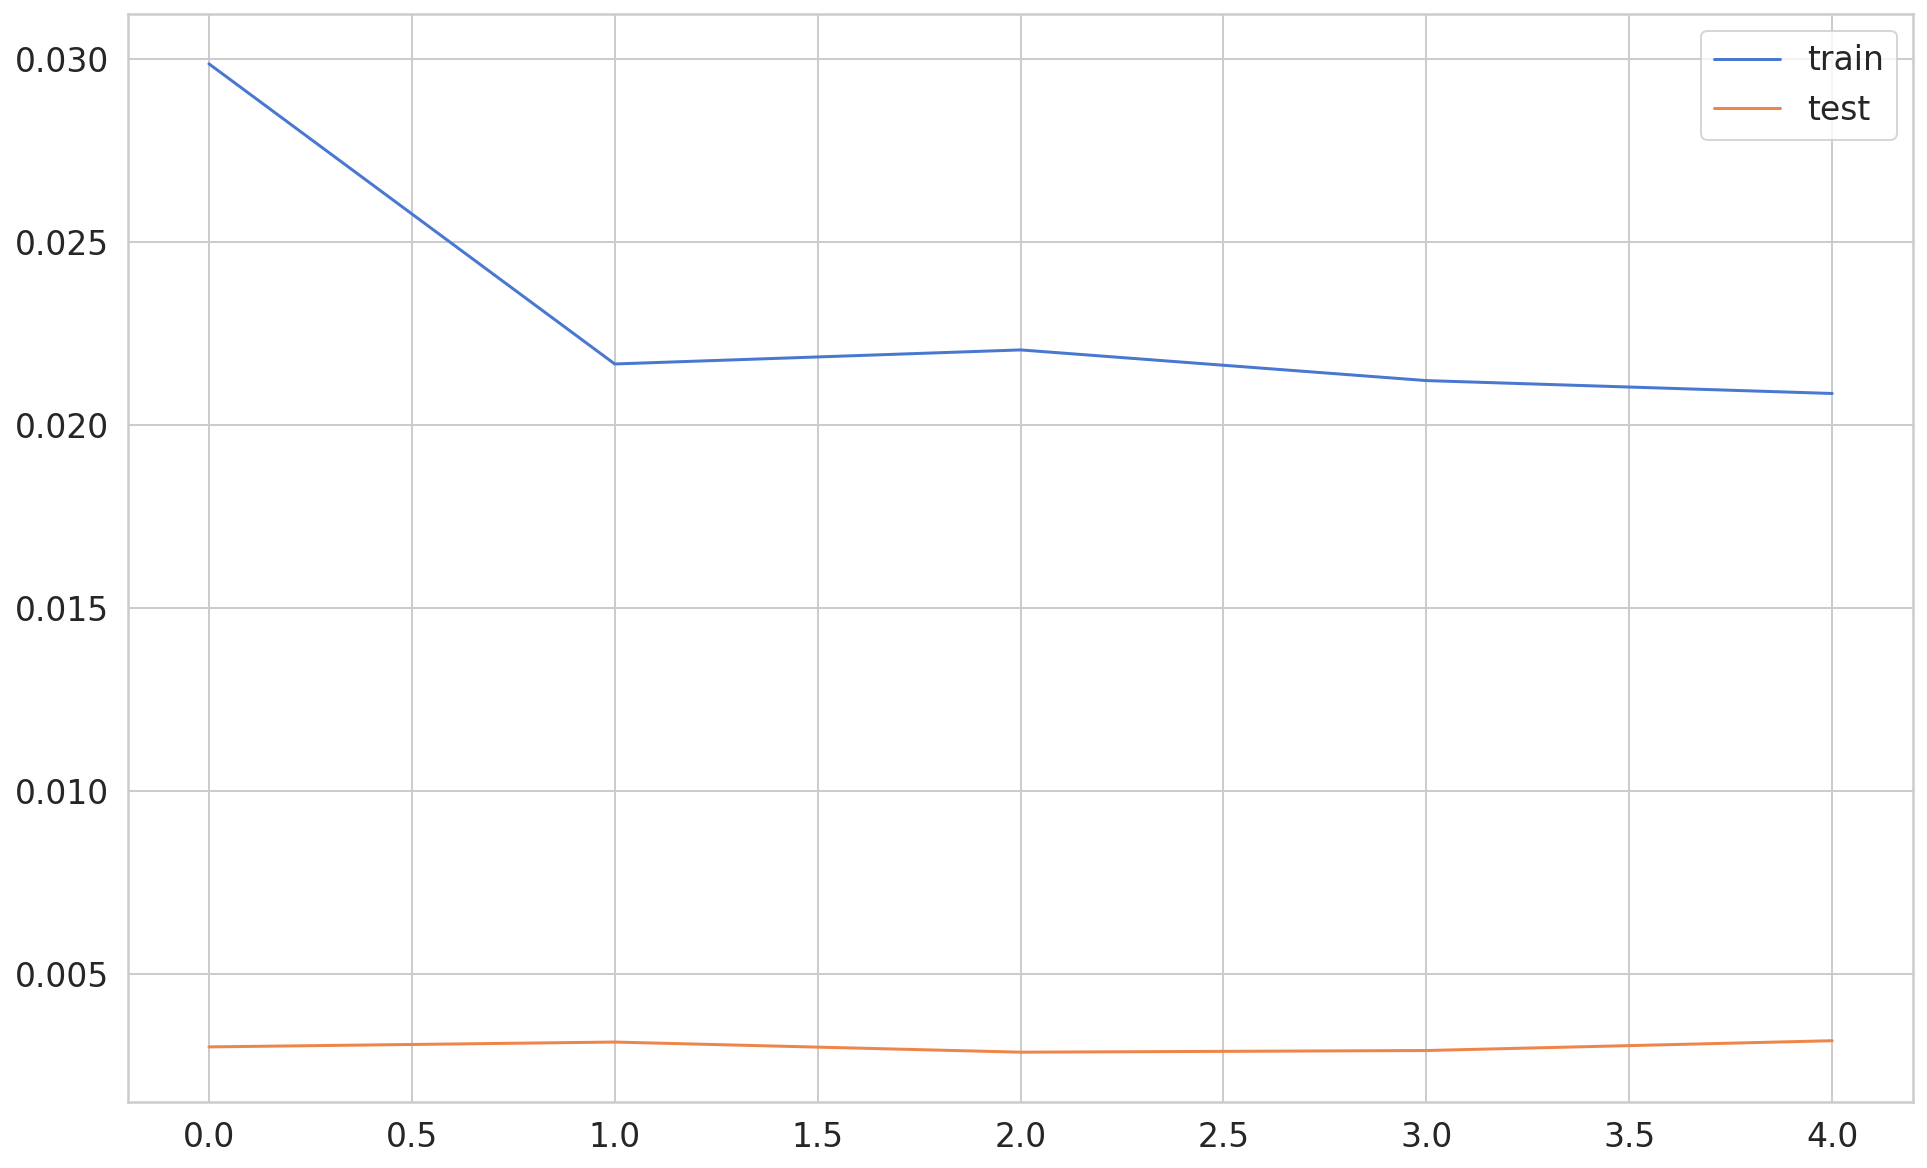

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [13]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_test.shape

y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_train.shape

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

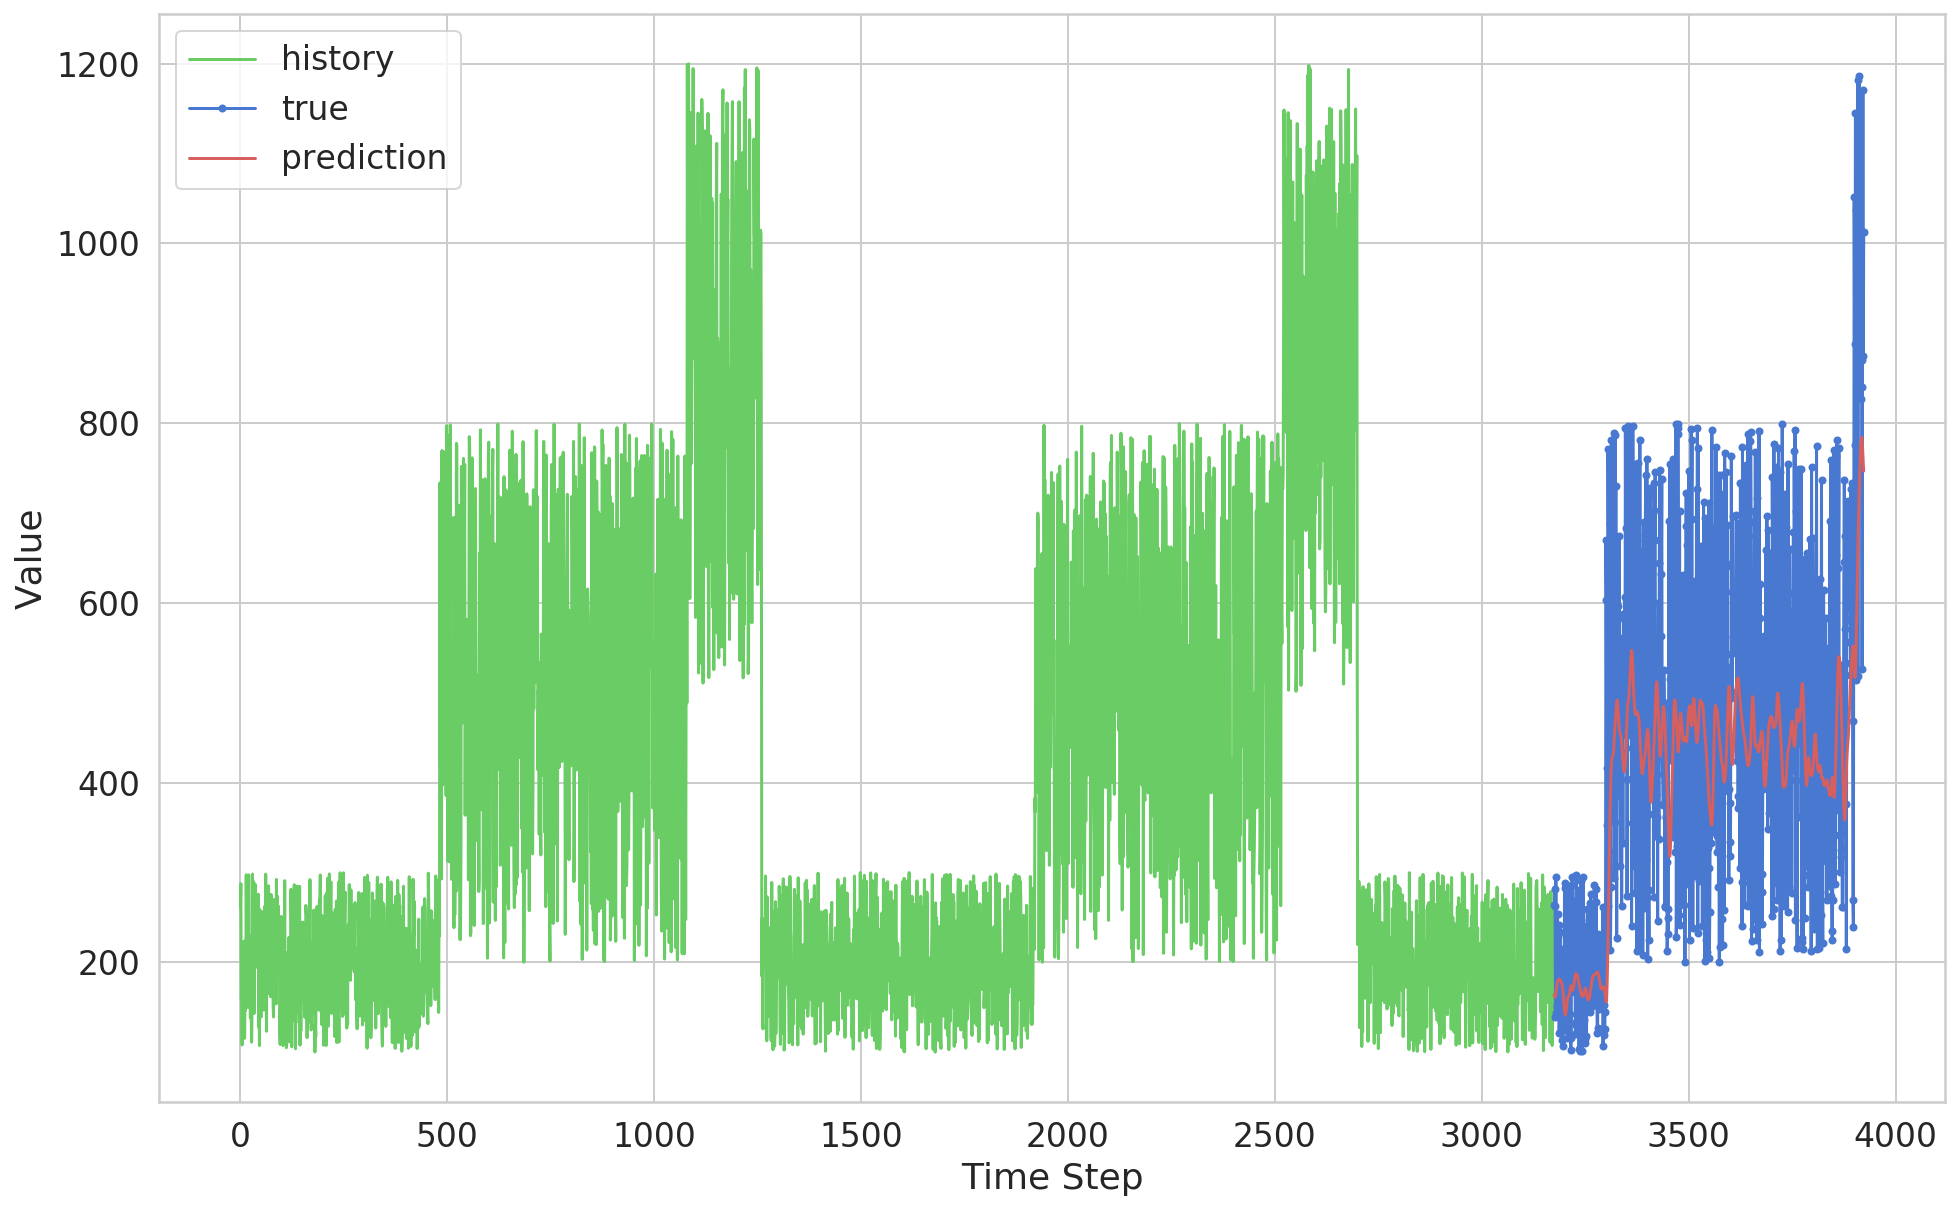

In [14]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

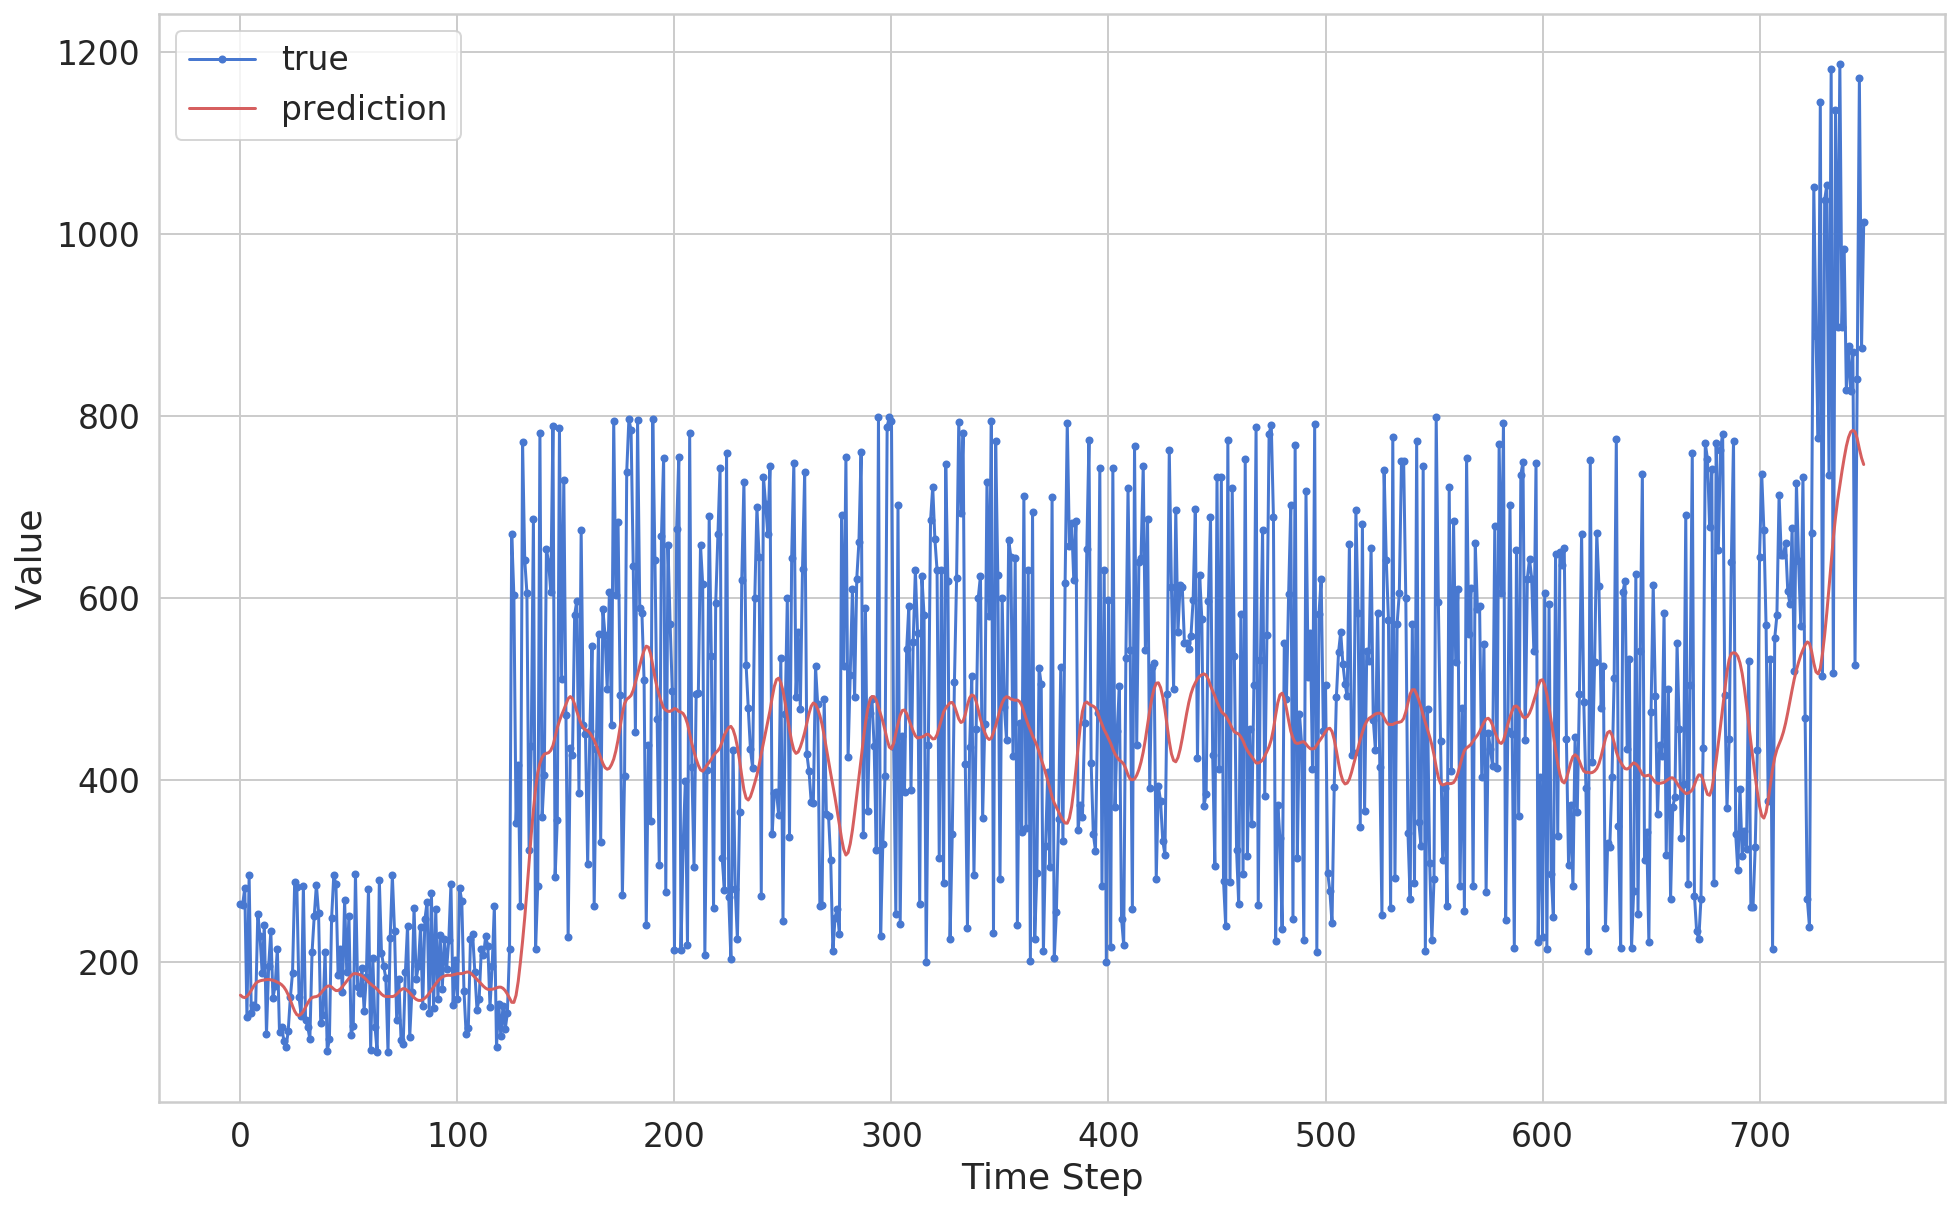

In [15]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# Save and Load Model

In [27]:
scores = model.evaluate(X_test, y_test, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# save model and architecture to single file
model.save("model.h5")

print(scores)
model.summary()

255485.96578771697


In [29]:
# load and evaluate a saved model
from tensorflow.keras.models import load_model

# load model
model = load_model('model.h5')

# summarize model.
# model.summary()

# load dataset
scores = model.evaluate(X_test, y_test, verbose=0)

print(scores)

255485.96578771697
